In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [2]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/My Drive/GAN/Shipibo GAN/")
!ls

Mounted at /content/drive
'Copy of Shipibo gan test 1.ipynb'   test_gif_128.mp4
 preproc			     test_gif_2.mp4
'Shipibo gan test 64.ipynb'	     test_gif_3.mp4
'shipibo test gan 128.ipynb'	     train_grid_128.mp4
'shipibo test gan 32.ipynb'	     train_grid.mp4


In [3]:
from keras.preprocessing.image import load_img,img_to_array
from PIL import Image

def load_images(path):
    """ loads images into a numpy array and returns them
    """
    img_paths = [path + f  for f in os.listdir(path)]
    print(len(img_paths))
    dataset_shape = (len(img_paths),64,64,3)

    data = np.ndarray(shape=dataset_shape)

    for i,f in enumerate(os.listdir(path)):
        im = Image.open(path + f)
        
        im = np.array(im)
        
        if i % 20 == 0:
            print("loaded ", i,"images" )

        data[i] = im.astype(int)
        

    print(data.shape)

    return data
data = load_images("preproc/64/")


Using TensorFlow backend.


402
loaded  0 images
loaded  20 images
loaded  40 images
loaded  60 images
loaded  80 images
loaded  100 images
loaded  120 images
loaded  140 images
loaded  160 images
loaded  180 images
loaded  200 images
loaded  220 images
loaded  240 images
loaded  260 images
loaded  280 images
loaded  300 images
loaded  320 images
loaded  340 images
loaded  360 images
loaded  380 images
loaded  400 images
(402, 64, 64, 3)


In [0]:
#warning, only run this once or else load the data all over again
data = (data - 127.5) / 127.5



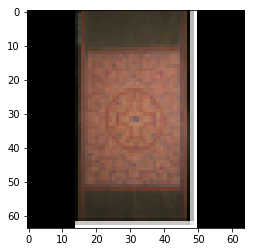

In [5]:
test = (data[0] + 1) / 2.0
plt.imshow(test)

In [0]:
def generate_real_samples(data,n_samples):
    
    rand_indexes = np.random.randint(0,data.shape[0],n_samples)
    
    X_samples = data[rand_indexes]
    y_samples = np.ones((n_samples,1))
    
    return X_samples,y_samples

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.optimizers import Adam

def make_discriminator(input_shape=(64,64,3)):
    
    model = Sequential()
    #normal layer
    model.add(Conv2D(64,(3,3),padding="same",input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    
    #downsample
    model.add(Conv2D(128,(3,3),strides=(2,2),padding="same"))
    
    model.add(LeakyReLU(alpha=0.2))
    
    #downsample
    model.add(Conv2D(128,(3,3),strides=(2,2),padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    
    #downsample
    model.add(Conv2D(256,(3,3),strides=(2,2),padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    #downsample
    model.add(Conv2D(256,(3,3),strides=(2,2),padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    
    #flatten then pass through fully connected layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation="sigmoid"))
    
    opt = Adam(lr=0.0002,beta_1=0.5)
    
    model.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])
    
    return model

In [0]:
from keras.layers import Reshape
from keras.layers import Conv2DTranspose

# define the standalone generator model
def make_generator(latent_dim=100):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #upsample to 64x64
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model


In [0]:
def generate_latent_points(n_samples,latent_dim=100):
    
    latent_points = np.random.randn(latent_dim*n_samples)
    
    latent_points = latent_points.reshape((n_samples,latent_dim))
    
    return latent_points

def generate_fake_samples(generator,n_samples,latent_dim=100):
    
    #first generate latent points, then pass them to the generator
    
    latent_points = generate_latent_points(n_samples,latent_dim)
    
    X_fake = generator.predict(latent_points)
    
    y_fake = np.zeros((n_samples,1))
    
    return X_fake,y_fake

In [0]:
def make_gan(discriminator,generator):
    
    model = Sequential()
    
    discriminator.trainable = False
    
    model.add(generator)
    
    model.add(discriminator)
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy",optimizer=opt)
    
    return model


In [11]:
import time

def train_gan(data,gan,discriminator,generator,n_epochs=200,batch_size=256):
    batch_per_epoch = 2 #int(data.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    
    n_points = 9
    fixed_latent_points = generate_latent_points(n_points)
    train_images = []
    
    gan_loss = []
    disc_loss = []
    
    
    for epoch in range(n_epochs):
        print("starting epoch",epoch)
        start_time = time.time()
        
        avg_epoch_disc_loss= []
        avg_epoch_gen_loss = []

        for batch in range(batch_per_epoch):
            
            #train the discriminator
            X_real,y_real = generate_real_samples(data,half_batch)
            X_fake,y_fake = generate_fake_samples(generator,half_batch)
            
            X,y = np.vstack((X_real,X_fake)) , np.vstack((y_real, y_fake))
            
            d_loss, _ = discriminator.train_on_batch(X,y)
            
            #train the generator (through the gan model by using the discriminator's error)
            lat_points = generate_latent_points(batch_size)
            y_gan = np.ones((batch_size,1))
            
            g_loss = gan.train_on_batch(lat_points,y_gan)
            
            
            #paint some pictures
            if epoch + 1 % 2 == 0:
                imgs = generator.predict(fixed_latent_points)

                #renormalize images for easy printing
                imgs = (imgs + 1) / 2.0
                train_images.append(imgs)
                
                #add loss to storage for graphing
                
                gan_loss.append(g_loss)
                disc_loss.append(d_loss)
            
            avg_epoch_disc_loss.append(d_loss)
            avg_epoch_gen_loss.append(g_loss)

        stop_time = time.time()
        print("avg loss over epoch, \nDiscriminator:" ,sum(avg_epoch_disc_loss)/len(avg_epoch_disc_loss),"\nGenerator:",sum(avg_epoch_gen_loss)/len(avg_epoch_gen_loss))
        print("epoch",epoch,"finished in",stop_time - start_time,"s\n\n")
            
            
    return train_images,gan_loss,disc_loss


reset_train = True

if reset_train:    
    discriminator = make_discriminator()
    generator = make_generator()

    gan = make_gan(discriminator,generator)



train_images,gan_loss,disc_loss = train_gan(data,gan,discriminator,generator,n_epochs=2000)            
            
     

W0816 12:22:15.070654 140620006520704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 12:22:15.088755 140620006520704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0816 12:22:15.092254 140620006520704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0816 12:22:15.187864 140620006520704 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0816 12:22:15.200717 

starting epoch 0


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


avg loss over epoch, 
Discriminator: 0.673981249332428 
Generator: 0.6933695673942566
epoch 0 finished in 10.328229188919067 s


starting epoch 1
avg loss over epoch, 
Discriminator: 0.5809665322303772 
Generator: 0.6925917863845825
epoch 1 finished in 2.540268659591675 s


starting epoch 2
avg loss over epoch, 
Discriminator: 0.46026818454265594 
Generator: 0.6710813045501709
epoch 2 finished in 2.5271248817443848 s


starting epoch 3
avg loss over epoch, 
Discriminator: 0.4580506831407547 
Generator: 0.6042868494987488
epoch 3 finished in 2.516691207885742 s


starting epoch 4
avg loss over epoch, 
Discriminator: 0.5283103287220001 
Generator: 0.6376795172691345
epoch 4 finished in 2.5442116260528564 s


starting epoch 5
avg loss over epoch, 
Discriminator: 0.45358070731163025 
Generator: 0.8175337612628937
epoch 5 finished in 2.526819944381714 s


starting epoch 6
avg loss over epoch, 
Discriminator: 0.37386828660964966 
Generator: 1.0478920936584473
epoch 6 finished in 2.5161921977

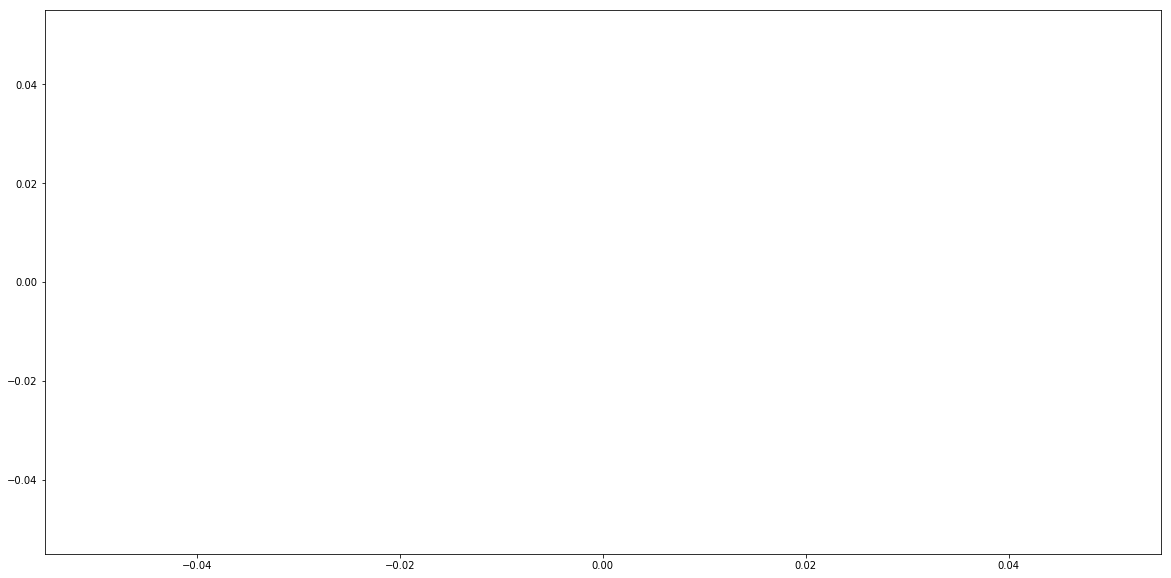

In [15]:
plt.figure(figsize=(20,10))

plt.plot(gan_loss)
plt.plot(disc_loss)

plt.show()

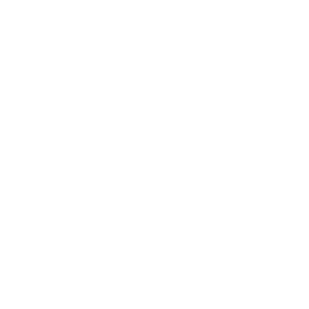

In [13]:
from matplotlib import animation

ims = []
fig = plt.figure()
ax = fig.add_axes([0,0,1,1], frameon=False, aspect=1)
ax.set_xticks([]); ax.set_yticks([])

for train_ims in train_images:

    

    im_1 = plt.imshow(train_ims[0,:,:],vmin=0, vmax=1, animated=True) #add first image for test
    
    ims.append([im_1])
    #plt.pause(0.1) 

mp4_writer =  animation.writers['ffmpeg']
writer = mp4_writer(fps=24, metadata=dict(artist='Me'), bitrate=1800)


anim = animation.ArtistAnimation(fig,ims)
anim.save("test_gif_3.mp4", writer= writer)

(3, 3)


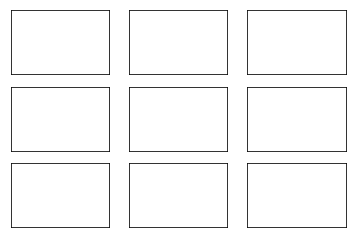

In [14]:
fig,axs = plt.subplots(3,3)

print(axs.shape)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

images = []

#iterate ove images
for imgs in train_images:
    ims = [] 
    for i,img in enumerate(imgs):
        
        line = i%3
        col = int(i/3)
        ims.append(axs[line,col].imshow(img[:,:],vmin=0, vmax=1, animated=True))
    
    images.append(ims)

mp4_writer =  animation.writers['ffmpeg']
writer = mp4_writer(fps=24, metadata=dict(artist='Me'), bitrate=1800)

anim = animation.ArtistAnimation(fig,images)
anim.save("train_grid.mp4", writer= writer)


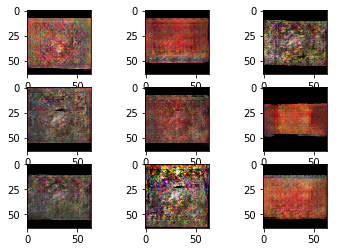

In [23]:
noise = generate_latent_points(9)
gen_ims = generator.predict(noise)

gen_ims = (gen_ims + 1) /2.0
for i,im in enumerate(gen_ims):

    plt.subplot(3,3,i+1)
    plt.imshow(im)
plt.show()